# TLT SSD example usecase

本教程将详细讲述如何利用NVIDIA Transfer Learning toolkit从头开始训练一个口罩检测的模型，并将模型转换成可以直接部署在NVIDIA GPU（Tesla & Jetson）上的格式.

0. [设置环境变量](#head-0)
1. [准备数据集和预训练模型](#head-1) <br>
    1.1 [将数据集转换成KITTI格式并生成TFrecord文件](#head-1-1) <br>
    1.2 [下载预训练模型](#head-1-2) <br>
2. [设置训练参数](#head-2)
3. [利用NVIDIA Transfer Learning Toolkit训练模型](#head-3)
4. [评估模型](#head-4)
5. [模型剪枝](#head-5)
6. [重新训练剪枝后的模型](#head-6)
7. [评估重新训练的模型](#head-7)
8. [可视化推理过程](#head-8)
9. [模型的导出和部署](#head-9)
10. [确认导出模型](#head-10)

## 0. 设置环境变量 <a class="anchor" id="head-0"></a>


In [1]:
# 设置环境变量，这里请注意KEY是需要您从NGC官网申请的，您可以从以下网址得到您自己的KEY：
#https://ngc.nvidia.com/catalog
#USER_EXPERIMENT_DIR是我们实验的目录
#DATA_DOWNLOAD_DIR是用来保存我们的数据样本和预训练模型
#SPECS_DIR是用来保存我们训练设置的超参
#以下设置仅代表作者本人的设置目录，需要用户根据自己的实际情况设置更新
print("Please replace the variable with your key.")
%set_env KEY=cTJhcms3ODdvbHRsOWwxMTNvYW0yN3NuaHA6YjU2YjE1ZjgtNDk5Ni00NTY5LWE0MDAtMjMwNzgwZWE5MGFj
%set_env USER_EXPERIMENT_DIR=/workspace-hekun/mydata/tlt-tensorrt-nano
%set_env DATA_DOWNLOAD_DIR=/workspace-hekun/mydata/tlt-tensorrt-nano/data
%set_env SPECS_DIR=/workspace-hekun/mydata/tlt-tensorrt-nano/specs
!mkdir -p $DATA_DOWNLOAD_DIR
!mkdir -p $SPECS_DIR

Please replace the variable with your key.
env: KEY=cTJhcms3ODdvbHRsOWwxMTNvYW0yN3NuaHA6YjU2YjE1ZjgtNDk5Ni00NTY5LWE0MDAtMjMwNzgwZWE5MGFj
env: USER_EXPERIMENT_DIR=/workspace-hekun/mydata/tlt-tensorrt-nano
env: DATA_DOWNLOAD_DIR=/workspace-hekun/mydata/tlt-tensorrt-nano/data
env: SPECS_DIR=/workspace-hekun/mydata/tlt-tensorrt-nano/specs


## 1. 准备训练数据集和下载预训练模型 <a class="anchor" id="head-1"></a>

In [2]:
#验证KEY是否设置成功，这个KEY非常重要，用户训练出来的模型在导出和转换时都需要
!echo $KEY

cTJhcms3ODdvbHRsOWwxMTNvYW0yN3NuaHA6YjU2YjE1ZjgtNDk5Ni00NTY5LWE0MDAtMjMwNzgwZWE5MGFj


 NVIDIA官方教程中使用的KITTI目标检测数据集，您可以通过以下网址下载：
 http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d.
 
 图片下载网址： (http://www.cvlibs.net/download.php?file=data_object_image_2.zip) 
 
 标注下载网址： (http://www.cvlibs.net/download.php?file=data_object_label_2.zip) 
 
 下载好之后，把数据集放到$DATA_DOWNLOAD_DIR文件夹中.

In [ ]:
# 查看上面下载的数据----这步当前实验可以不运行
!mkdir -p $DATA_DOWNLOAD_DIR
!if [ ! -f $DATA_DOWNLOAD_DIR/data_object_image_2.zip ]; then echo 'Image zip file not found, please download.'; else echo 'Found Image zip file.';fi
!if [ ! -f $DATA_DOWNLOAD_DIR/data_object_label_2.zip ]; then echo 'Label zip file not found, please download.'; else echo 'Found Labels zip file.';fi

In [ ]:
# 解压----这步当前实验可以不运行
!unzip -u $DATA_DOWNLOAD_DIR/data_object_image_2.zip -d $DATA_DOWNLOAD_DIR
!unzip -u $DATA_DOWNLOAD_DIR/data_object_label_2.zip -d $DATA_DOWNLOAD_DIR

In [44]:
# 确认
!ls -l $DATA_DOWNLOAD_DIR/

total 1556
-rw-r--r-- 1 root root    720 May 27 22:31 changename.py
-rw-r--r-- 1 root root    318 May 27 22:31 check.py
drwxr-xr-x 2 root root 475136 May 27 22:51 images
drwxr-xr-x 2 root root   4096 May 28 04:04 infer_images
drwxr-xr-x 2 root root   4096 May 28 04:05 infered_images
drwxr-xr-x 2 root root 450560 May 27 22:51 labels
drwxr-xr-x 6 root root   4096 May 27 22:53 train
drwxr-xr-x 4 root root   4096 May 27 22:58 xml2kitti
drwxr-xr-x 2 root root 638976 May 27 22:31 xmlfiles


* 我们本次实验使用的是网上多个数据集混合的训练样本，VOC格式的.xml数据标注方式，需要用户自己讲标注文件转换成KITTI的格式

* 在本次实验当前的目录下，‘data’文件夹下的‘images’保存的是处理好的训练图片，‘labels’文件夹保存的是训练样本的标注文件

* "xmlfiles"文件夹保存的是转换前的标注文件

* "xml2kitti"文件夹保存的是转换VOC的.xml文件到KITT格式的工具

* changename.py是用来统一更改后缀名的工具

* check.py是用来检查图片是否有损坏的工具（比如某个作者之前遇到的错误是某个图片以‘BM’开头，系统会报告格式错误）

### 1.1 将准备好的训练数据从KITTI格式生成TFrecords格式 <a class="anchor" id="head-1-1"></a>

* 更改在specs文件夹中的ssd_tfrecords_kitti_trainval.txt中的参数，指定训练样本的路径
* 利用tlt-dataset-convert 生成TFrecords文件
* TFRecords文件只需要生成一次既可
* 注意这里的路径都是作者本人的环境路径，请用户自行更换成自己的环境路径

In [5]:
print("TFrecords conversion spec file for training")
!cat $SPECS_DIR/ssd_tfrecords_kitti_trainval.txt

TFrecords conversion spec file for training
kitti_config {
  root_directory_path: "/workspace-hekun/mydata/tlt-tensorrt-nano/data/train"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".JPEG"
  partition_mode: "random"
  num_partitions: 2
  val_split: 14
  num_shards: 10
}
image_directory_path: "/workspace-hekun/mydata/tlt-tensorrt-nano/data/train/images"

In [6]:
# 创建一个新的文件夹来存储tfrecords文件.
!mkdir -p $USER_EXPERIMENT_DIR/tfrecords
#创建tfrecords文件 ‘-d’指的是设置文件，就是我们上一步更改的那个，‘-o’指的是输出
#目录。
!tlt-dataset-convert -d $SPECS_DIR/ssd_tfrecords_kitti_trainval.txt \
                     -o $USER_EXPERIMENT_DIR/tfrecords/kitti_trainval/kitti_trainval

Using TensorFlow backend.
2020-05-27 23:08:20,572 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2020-05-27 23:08:20,572 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Creating output directory /workspace-hekun/mydata/tlt-tensorrt-nano/tfrecords/kitti_trainval
2020-05-27 23:08:20,595 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 6841	Val: 1113
2020-05-27 23:08:20,595 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2020-05-27 23:08:20,597 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0
/usr/local/lib/python2.7/dist-packages/iva/detectnet_v2/dataio/kitti_converter_lib.py:266: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
2020-05-27 23:08:20,724 - 

In [7]:
#查看生成的文件
!ls -rlt $USER_EXPERIMENT_DIR/tfrecords/kitti_trainval

total 5352
-rw-r--r-- 1 root root  73316 May 27 23:08 kitti_trainval-fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root  76271 May 27 23:08 kitti_trainval-fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 root root  79311 May 27 23:08 kitti_trainval-fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 root root  77410 May 27 23:08 kitti_trainval-fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 root root  75362 May 27 23:08 kitti_trainval-fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 root root  74860 May 27 23:08 kitti_trainval-fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 root root  76583 May 27 23:08 kitti_trainval-fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 root root  72739 May 27 23:08 kitti_trainval-fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 root root  73722 May 27 23:08 kitti_trainval-fold-000-of-002-shard-00008-of-00010
-rw-r--r-- 1 root root  75013 May 27 23:08 kitti_trainval-fold-000-of-002-shard-00009-of-00010
-rw-r--r-- 1 root root 470856 May 27 23

### 1.2 下载预训练模型 <a class="anchor" id="head-1-2"></a>

您可以通过一下命令下载模型，也可以通过手动的方式下载预训练模型：
[ngc.nvidia.com](ngc.nvidia.com)

In [8]:
#查看当前目标检测可用的预训练模型
!ngc registry model list nvidia/tlt_pretrained_object_detection:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| resne | 74.38 | 80    | 1     | V100  | 38.3  | 38.31 | UPLOA | Apr   |
| t10   |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| resne | 76.74 | 80    | 1     | V100  | 89.0  | 88.96 | UPLOA | Apr   |
| t18   |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| resne | 77.04 | 80    | 1     | V100  | 170.7 | 170.6 | UPLOA | Apr   |
| t34   |       |       |       |     

In [9]:
#创建一个新的文件夹，存储下载好的预训练模型
!mkdir -p $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/tlt_pretrained_object_detection_mobilenet_v2

In [ ]:
# Pull pretrained model from NGC
!ngc registry model download-version nvidia/tlt_pretrained_object_detection:resnet18 --dest $USER_EXPERIMENT_DIR/pretrained_resnet18

In [12]:
print("查看下载好的预训练模型.")
!ls -l $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/tlt_pretrained_object_detection_mobilenet_v2

查看下载好的预训练模型.
total 5136
-rwxr-xr-x 1 root root 5258048 May 27 23:22 mobilenet_v2.hdf5


## 2. 设置训练的超参 <a class="anchor" id="head-2"></a>
* 训练数据集
    * 为了使用最新生成TFrecords文件，在 `$SPECS_DIR/ssd_train_resnet18_kitti.txt`设置文件路径 
    * Update the fold number to use for evaluation. In case of random data split, please use fold 0 only
    * 更新测试样本数量，如果随机生成，可以设置成0
* 预训练模型
* 其他超参比如batch size，learning rate等等

In [14]:
!cat $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.05, 0.1, 0.25, 0.4, 0.55, 0.7, 0.85]"
  two_boxes_for_ar1: true
  clip_boxes: false
  loss_loc_weight: 0.8
  focal_loss_alpha: 0.25
  focal_loss_gamma: 2.0
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "mobilenet_v2"
  freeze_bn: false
}
training_config {
  batch_size_per_gpu: 64
  num_epochs: 100
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-7
    max_learning_rate: 5e-3
    soft_start: 0.1
    annealing: 0.3
    }
  }
  regularizer {
    type: L2
    weight: 0.00004
  }
}
eval_config {
  validation_period_during_training: 5
  average_precision_mode: SAMPLE
  batch_size: 32
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
  preprocessing {
    output_image_width: 300
    output_image_height: 300
    output_image_channel: 3
    crop_right: 300
    crop_bottom: 300
  

## 3. 开始训练模型 <a class="anchor" id="head-3"></a>
* 需要提供预训练模型、specs文件夹中的设置文件地址以及输出文件夹
* 注意：训练课程会持续好几个小时或者一天

In [15]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_unpruned

In [16]:
print("如果想用多个GPU可以更改 ‘--gpus’的参数")
!tlt-train ssd -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
               -k $KEY \
               -m /workspace-hekun/mydata/tlt-tensorrt-nano/pretrained_mobilenet_v2/tlt_pretrained_object_detection_mobilenet_v2/mobilenet_v2.hdf5 \
               --gpus 1

如果想用多个GPU可以更改 ‘--gpus’的参数
Using TensorFlow backend.
2020-05-27 23:34:28,868 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace-hekun/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop ar

target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is

block_4_project (Conv2D)        (64, 32, 38, 38)     6144        block_4_relu[0][0]               
__________________________________________________________________________________________________
block_4_projected_inputs (Conv2 (64, 32, 38, 38)     1024        block_3_project_bn[0][0]         
__________________________________________________________________________________________________
block_4_project_bn (BatchNormal (64, 32, 38, 38)     128         block_4_project[0][0]            
__________________________________________________________________________________________________
block_4_add (Add)               (64, 32, 38, 38)     0           block_4_projected_inputs[0][0]   
                                                                 block_4_project_bn[0][0]         
__________________________________________________________________________________________________
block_5_expand (Conv2D)         (64, 192, 38, 38)    6144        block_4_add[0][0]                
__________

Epoch 1/100
107/107 [==============================] - 138s 1s/step - loss: 2610.2181

Epoch 00001: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_001.tlt
Epoch 2/100
107/107 [==============================] - 89s 832ms/step - loss: 970.6612

Epoch 00002: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_002.tlt
Epoch 3/100
107/107 [==============================] - 89s 832ms/step - loss: 93.1017

Epoch 00003: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_003.tlt
Epoch 4/100
107/107 [==============================] - 89s 832ms/step - loss: 22.1699

Epoch 00004: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_004.tlt
Epoch 5/100
107/107 [==============================] - 90s 841ms/step - loss: 12.7763

Epoch 00005: saving model to

107/107 [==============================] - 90s 837ms/step - loss: 1.0599

Epoch 00058: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_058.tlt
Epoch 59/100
107/107 [==============================] - 89s 836ms/step - loss: 1.0657

Epoch 00059: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_059.tlt
Epoch 60/100
107/107 [==============================] - 90s 838ms/step - loss: 1.0607

Epoch 00060: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_060.tlt
Number of images in the evaluation dataset: 1113

Producing predictions: 100%|████████████████████| 35/35 [00:26<00:00,  1.31it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
face          AP    0.534
face_mask     AP    0.763
              mAP   0.649
*******************************
Ep

107/107 [==============================] - 89s 831ms/step - loss: 1.0608

Epoch 00086: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_086.tlt
Epoch 87/100
107/107 [==============================] - 88s 826ms/step - loss: 1.0533

Epoch 00087: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_087.tlt
Epoch 88/100
107/107 [==============================] - 88s 827ms/step - loss: 1.0438

Epoch 00088: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_088.tlt
Epoch 89/100
107/107 [==============================] - 89s 829ms/step - loss: 1.0666

Epoch 00089: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_089.tlt
Epoch 90/100
107/107 [==============================] - 89s 832ms/step - loss: 1.0655

Epoch 00090: saving model to /workspace-he

In [17]:
#查看训练出来的模型
!ls /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/

ssd_mobilenet_v2_epoch_001.tlt	ssd_mobilenet_v2_epoch_051.tlt
ssd_mobilenet_v2_epoch_002.tlt	ssd_mobilenet_v2_epoch_052.tlt
ssd_mobilenet_v2_epoch_003.tlt	ssd_mobilenet_v2_epoch_053.tlt
ssd_mobilenet_v2_epoch_004.tlt	ssd_mobilenet_v2_epoch_054.tlt
ssd_mobilenet_v2_epoch_005.tlt	ssd_mobilenet_v2_epoch_055.tlt
ssd_mobilenet_v2_epoch_006.tlt	ssd_mobilenet_v2_epoch_056.tlt
ssd_mobilenet_v2_epoch_007.tlt	ssd_mobilenet_v2_epoch_057.tlt
ssd_mobilenet_v2_epoch_008.tlt	ssd_mobilenet_v2_epoch_058.tlt
ssd_mobilenet_v2_epoch_009.tlt	ssd_mobilenet_v2_epoch_059.tlt
ssd_mobilenet_v2_epoch_010.tlt	ssd_mobilenet_v2_epoch_060.tlt
ssd_mobilenet_v2_epoch_011.tlt	ssd_mobilenet_v2_epoch_061.tlt
ssd_mobilenet_v2_epoch_012.tlt	ssd_mobilenet_v2_epoch_062.tlt
ssd_mobilenet_v2_epoch_013.tlt	ssd_mobilenet_v2_epoch_063.tlt
ssd_mobilenet_v2_epoch_014.tlt	ssd_mobilenet_v2_epoch_064.tlt
ssd_mobilenet_v2_epoch_015.tlt	ssd_mobilenet_v2_epoch_065.tlt
ssd_mobilenet_v2_epoch_016.tlt	ssd_mobilenet_v2_epoch_066.tlt
ssd_mobi

In [ ]:
print("To resume from checkpoint, please uncomment and run this instead. Change last two arguments accordingly.")
# !tlt-train ssd -e $SPECS_DIR/ssd_train_resnet18_kitti.txt \
#                -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
#                -k $KEY \
#                -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_resnet18_epoch_001.tlt \
#                --gpus 1 \
#                --initial_epoch 2 

In [18]:
#查看训练出来的模型
print('Model for each epoch:')
print('---------------------')
!ls -ltrh $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
total 502M
-rw-r--r-- 1 root root 5.1M May 28 00:06 ssd_mobilenet_v2_epoch_001.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:08 ssd_mobilenet_v2_epoch_002.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:10 ssd_mobilenet_v2_epoch_003.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:11 ssd_mobilenet_v2_epoch_004.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:13 ssd_mobilenet_v2_epoch_005.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:15 ssd_mobilenet_v2_epoch_006.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:16 ssd_mobilenet_v2_epoch_007.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:18 ssd_mobilenet_v2_epoch_008.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:19 ssd_mobilenet_v2_epoch_009.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:21 ssd_mobilenet_v2_epoch_010.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:23 ssd_mobilenet_v2_epoch_011.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:24 ssd_mobilenet_v2_epoch_012.tlt
-rw-r--r-- 1 root root 5.1M May 28 00:26 ssd_mobilenet_v2_epoch_013.tlt
-rw-r--r-

In [21]:
# 接下来通过评估的测试结果来选择一个训练效果最好的模型
# Note csv epoch number is 1 less than model file epoch. For example, epoch 79 in csv corresponds to _080.tlt
!cat $USER_EXPERIMENT_DIR/experiment_dir_unpruned/ssd_training_log_mobilenet_v2.csv
%set_env EPOCH=100

epoch,AP_face,AP_face_mask,loss,mAP
0,nan,nan,2610.218051803446,nan
1,nan,nan,970.6612330641702,nan
2,nan,nan,93.10172838585399,nan
3,nan,nan,22.16986682927497,nan
4,0.0018552875695732837,0.013050655438188157,12.776269337841283,0.00745297150388072
5,nan,nan,8.484413601527704,nan
6,nan,nan,6.236217935508657,nan
7,nan,nan,4.509514189212122,nan
8,nan,nan,3.3303613707283946,nan
9,0.03405706889395007,0.029773541192888515,2.590635465684338,0.031915305043419294
10,nan,nan,2.1273466404353347,nan
11,nan,nan,1.868531916743127,nan
12,nan,nan,1.7244900710114808,nan
13,nan,nan,1.6538292893739504,nan
14,0.09755180666524509,0.2232337857580659,1.514527037879017,0.1603927962116555
15,nan,nan,1.51124816965834,nan
16,nan,nan,1.4421490464255073,nan
17,nan,nan,1.4184170616007297,nan
18,nan,nan,1.3969787459507166,nan
19,0.3049275213068158,0.6470374315451367,1.362351855942022,0.47598247642597624
20,nan,nan,1.3494420352383194,nan
21,nan,nan,1.2926509580879568,nan
22,nan,nan,1.3026078777892567,nan
23,nan,nan,1

## 4. 评估训练好的模型 <a class="anchor" id="head-4"></a>

In [22]:
!tlt-evaluate ssd -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                  -k $KEY

Using TensorFlow backend.
2020-05-28 02:46:10,673 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace-hekun/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains 

## 5. 模型剪枝 <a class="anchor" id="head-5"></a>
* 设置剪枝的阈值
* 设置选择剪枝的模型，也就是我们之前通过评估选择的那个模型
* 设置输出路径

通常，我们需要设置‘-pth’参数来平衡模型的精度与模型的大小（或者说速度）。更高的‘-pth’数值，会让模型更小（更快的推理速度），但是也会降低模型精度。在本次实验中，作者使用的是0.5，如果精度没问题，我们可以增加‘-pth’的数值，来进一步剪枝。反之，我们则需要减小‘-pth’的数值。

In [23]:
#创建新的文件夹，保存剪枝后的模型
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_pruned

In [24]:
#开始模型剪枝
!tlt-prune -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
           -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_mobilenet_v2_pruned.tlt \
           -eq intersection \
           -pth 0.5 \
           -k $KEY

Using TensorFlow backend.
2020-05-28 02:47:37,360 [INFO] modulus.pruning.pruning: Exploring graph for retainable indices
2020-05-28 02:47:40,886 [INFO] modulus.pruning.pruning: Pruning model and appending pruned nodes to new graph
2020-05-28 02:50:31,033 [INFO] iva.common.magnet_prune: Pruning ratio (pruned model / original model): 0.634463671576


In [25]:
#查看剪枝后的模型
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_pruned/

total 3448
-rw-r--r-- 1 root root 3529264 May 28 02:50 ssd_mobilenet_v2_pruned.tlt


## 6. 重新训练剪枝后的模型 <a class="anchor" id="head-6"></a>
* 模型在剪枝后需要重新训练
* 还需要定义重新训练的参数，比如学习率等。
* 注意：重新训练也需要比较长的时间

In [28]:
# 在这里我们打印出训练的超参
# 在ssd_retrain_mobilenet_v2_kitti.txt文件中我们需要定义训练设置，
# 还可以通过调整数据集来取得更好的训练效果
!cat $SPECS_DIR/ssd_retrain_mobilenet_v2_kitti.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.05, 0.1, 0.25, 0.4, 0.55, 0.7, 0.85]"
  two_boxes_for_ar1: true
  clip_boxes: false
  loss_loc_weight: 0.8
  focal_loss_alpha: 0.25
  focal_loss_gamma: 2.0
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "mobilenet_v2"
  freeze_bn: false
}
training_config {
  batch_size_per_gpu: 64
  num_epochs: 40
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-7
    max_learning_rate: 5e-3
    soft_start: 0.05
    annealing: 0.2
    }
  }
  regularizer {
    type: L2
    weight: 0.000004
  }
}
eval_config {
  validation_period_during_training: 5
  average_precision_mode: SAMPLE
  batch_size: 32
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
  preprocessing {
    output_image_width: 300
    output_image_height: 300
    output_image_channel: 3
    crop_right: 300
    crop_bottom: 300
 

In [27]:
# 创建一个新的文件夹，来保存重新训练的模型
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_retrain

In [29]:
# 使剪之后的模型作为预训练模型，重新训练
!tlt-train ssd --gpus 1 \
               -e $SPECS_DIR/ssd_retrain_mobilenet_v2_kitti.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
               -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_mobilenet_v2_pruned.tlt \
               -k $KEY

Using TensorFlow backend.
2020-05-28 02:53:27,501 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace-hekun/mydata/tlt-tensorrt-nano/specs/ssd_retrain_mobilenet_v2_kitti.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contain

target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is

ssd_expand_block_4_relu_0 (ReLU (64, 64, 3, 3)       0           ssd_expand_block_4_conv_0[0][0]  
__________________________________________________________________________________________________
ssd_expand_block_4_conv_1 (Conv (64, 128, 2, 2)      73728       ssd_expand_block_4_relu_0[0][0]  
__________________________________________________________________________________________________
ssd_expand_block_4_bn_1 (BatchN (64, 128, 2, 2)      512         ssd_expand_block_4_conv_1[0][0]  
__________________________________________________________________________________________________
ssd_expand_block_4_relu_1 (ReLU (64, 128, 2, 2)      0           ssd_expand_block_4_bn_1[0][0]    
__________________________________________________________________________________________________
ssd_conf_0 (Conv2D)             (64, 12, 38, 38)     12108       re_lu_7[0][0]                    
__________________________________________________________________________________________________
ssd_conf_1

Epoch 1/40
107/107 [==============================] - 119s 1s/step - loss: 7.5043

Epoch 00001: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_001.tlt
Epoch 2/40
107/107 [==============================] - 70s 657ms/step - loss: 2.8589

Epoch 00002: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_002.tlt
Epoch 3/40
107/107 [==============================] - 70s 656ms/step - loss: 1.5947

Epoch 00003: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_003.tlt
Epoch 4/40
107/107 [==============================] - 70s 654ms/step - loss: 1.3079

Epoch 00004: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_004.tlt
Epoch 5/40
107/107 [==============================] - 70s 653ms/step - loss: 1.2691

Epoch 00005: saving model to /workspace-hekun

Number of images in the evaluation dataset: 1113

Producing predictions: 100%|████████████████████| 35/35 [00:23<00:00,  1.48it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
face          AP    0.482
face_mask     AP    0.716
              mAP   0.599
*******************************
Epoch 31/40
107/107 [==============================] - 70s 658ms/step - loss: 1.0136

Epoch 00031: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_031.tlt
Epoch 32/40
107/107 [==============================] - 70s 657ms/step - loss: 1.0151

Epoch 00032: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_032.tlt
Epoch 33/40
107/107 [==============================] - 70s 656ms/step - loss: 1.0313

Epoch 00033: saving model to /workspace-hekun/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_033

In [30]:
# 查看最新训练出来的模型.
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights

total 137920
-rw-r--r-- 1 root root 3529264 May 28 03:07 ssd_mobilenet_v2_epoch_001.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:09 ssd_mobilenet_v2_epoch_002.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:10 ssd_mobilenet_v2_epoch_003.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:11 ssd_mobilenet_v2_epoch_004.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:12 ssd_mobilenet_v2_epoch_005.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:14 ssd_mobilenet_v2_epoch_006.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:15 ssd_mobilenet_v2_epoch_007.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:16 ssd_mobilenet_v2_epoch_008.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:17 ssd_mobilenet_v2_epoch_009.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:19 ssd_mobilenet_v2_epoch_010.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:20 ssd_mobilenet_v2_epoch_011.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:21 ssd_mobilenet_v2_epoch_012.tlt
-rw-r--r-- 1 root root 3529264 May 28 03:23 ssd_mobilenet_v2_epoch_013.tlt
-rw-r--r-- 1

In [34]:
# 现在，您可以在.CVS文件中查看模型的评估结果
# 注意.CVS文件中的序号比实际训练的序号小1, epoch 79 模型指的是第80个.tlt
!cat $USER_EXPERIMENT_DIR/experiment_dir_retrain/ssd_training_log_mobilenet_v2.csv
%set_env EPOCH=040

epoch,AP_face,AP_face_mask,loss,mAP
0,nan,nan,7.504330947020343,nan
1,nan,nan,2.858906433961102,nan
2,nan,nan,1.5947375481373796,nan
3,nan,nan,1.3079496432687634,nan
4,0.0038641946007098756,0.10593492798908263,1.2691410997203578,0.05489956129489625
5,nan,nan,1.2308424215450464,nan
6,nan,nan,1.1828270019771896,nan
7,nan,nan,1.1514292019549932,nan
8,nan,nan,1.132974583968938,nan
9,0.1642043252593896,0.39563097641397377,1.094625239060304,0.2799176508366817
10,nan,nan,1.0725580431590571,nan
11,nan,nan,1.063763334929386,nan
12,nan,nan,1.0526665421289818,nan
13,nan,nan,1.0546669726059816,nan
14,0.3834961161730847,0.5945546932436448,1.0036189155043842,0.48902540470836475
15,nan,nan,1.0367281832427622,nan
16,nan,nan,1.0225604460618207,nan
17,nan,nan,1.0245209804205138,nan
18,nan,nan,1.0237440544868184,nan
19,0.4643157074115993,0.6842463106840652,1.0155517197100916,0.5742810090478322
20,nan,nan,1.0357138653781925,nan
21,nan,nan,0.9984421735612031,nan
22,nan,nan,1.0180902024295841,nan
23,nan,nan

## 7. 评估预训练模型 <a class="anchor" id="head-7"></a>

In [35]:
!tlt-evaluate ssd -e $SPECS_DIR/ssd_retrain_mobilenet_v2_kitti.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                  -k $KEY

Using TensorFlow backend.
2020-05-28 04:03:41,708 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace-hekun/mydata/tlt-tensorrt-nano/specs/ssd_retrain_mobilenet_v2_kitti.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contain

## 8. 可视化推理结果 <a class="anchor" id="head-8"></a>
在这个部分，我们利用tlt-infer在我们训练的模型的基础上进行推理，并且可视化结果

In [36]:
# Running inference for detection on n images
!tlt-infer ssd -i $DATA_DOWNLOAD_DIR/infer_images \
               -o $USER_EXPERIMENT_DIR/data/infered_images \
               -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
               -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
               -l $USER_EXPERIMENT_DIR/ssd_infer_labels \
               -k $KEY

Using TensorFlow backend.
2020-05-28 04:05:39,832 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace-hekun/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 3, 300, 300)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 3, 302, 302)  0           Input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 150, 150) 432         conv1_pad[0][0]                  
________________________________________________________________________

re_lu_9 (ReLU)                  (None, 144, 19, 19)  0           block_8_expand_bn[0][0]          
__________________________________________________________________________________________________
block_8_depthwise_pad (ZeroPadd (None, 144, 21, 21)  0           re_lu_9[0][0]                    
__________________________________________________________________________________________________
block_8_depthwise (DepthwiseCon (None, 144, 19, 19)  1296        block_8_depthwise_pad[0][0]      
__________________________________________________________________________________________________
block_8_depthwise_bn (BatchNorm (None, 144, 19, 19)  576         block_8_depthwise[0][0]          
__________________________________________________________________________________________________
block_8_relu (ReLU)             (None, 144, 19, 19)  0           block_8_depthwise_bn[0][0]       
__________________________________________________________________________________________________
block_8_pr

100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  3.97it/s]


`tlt-infer`工具会输出两个文件
1. 推理检测出来的图片，保存在`$USER_EXPERIMENT_DIR/ssd_infer_images`文件夹中
2. 每一帧的bounding box标注文件会以KITTI的格式保存在`$USER_EXPERIMENT_DIR/ssd_infer_labels`文件夹中

In [37]:
# 简单的写一个可视化工具
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx / num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

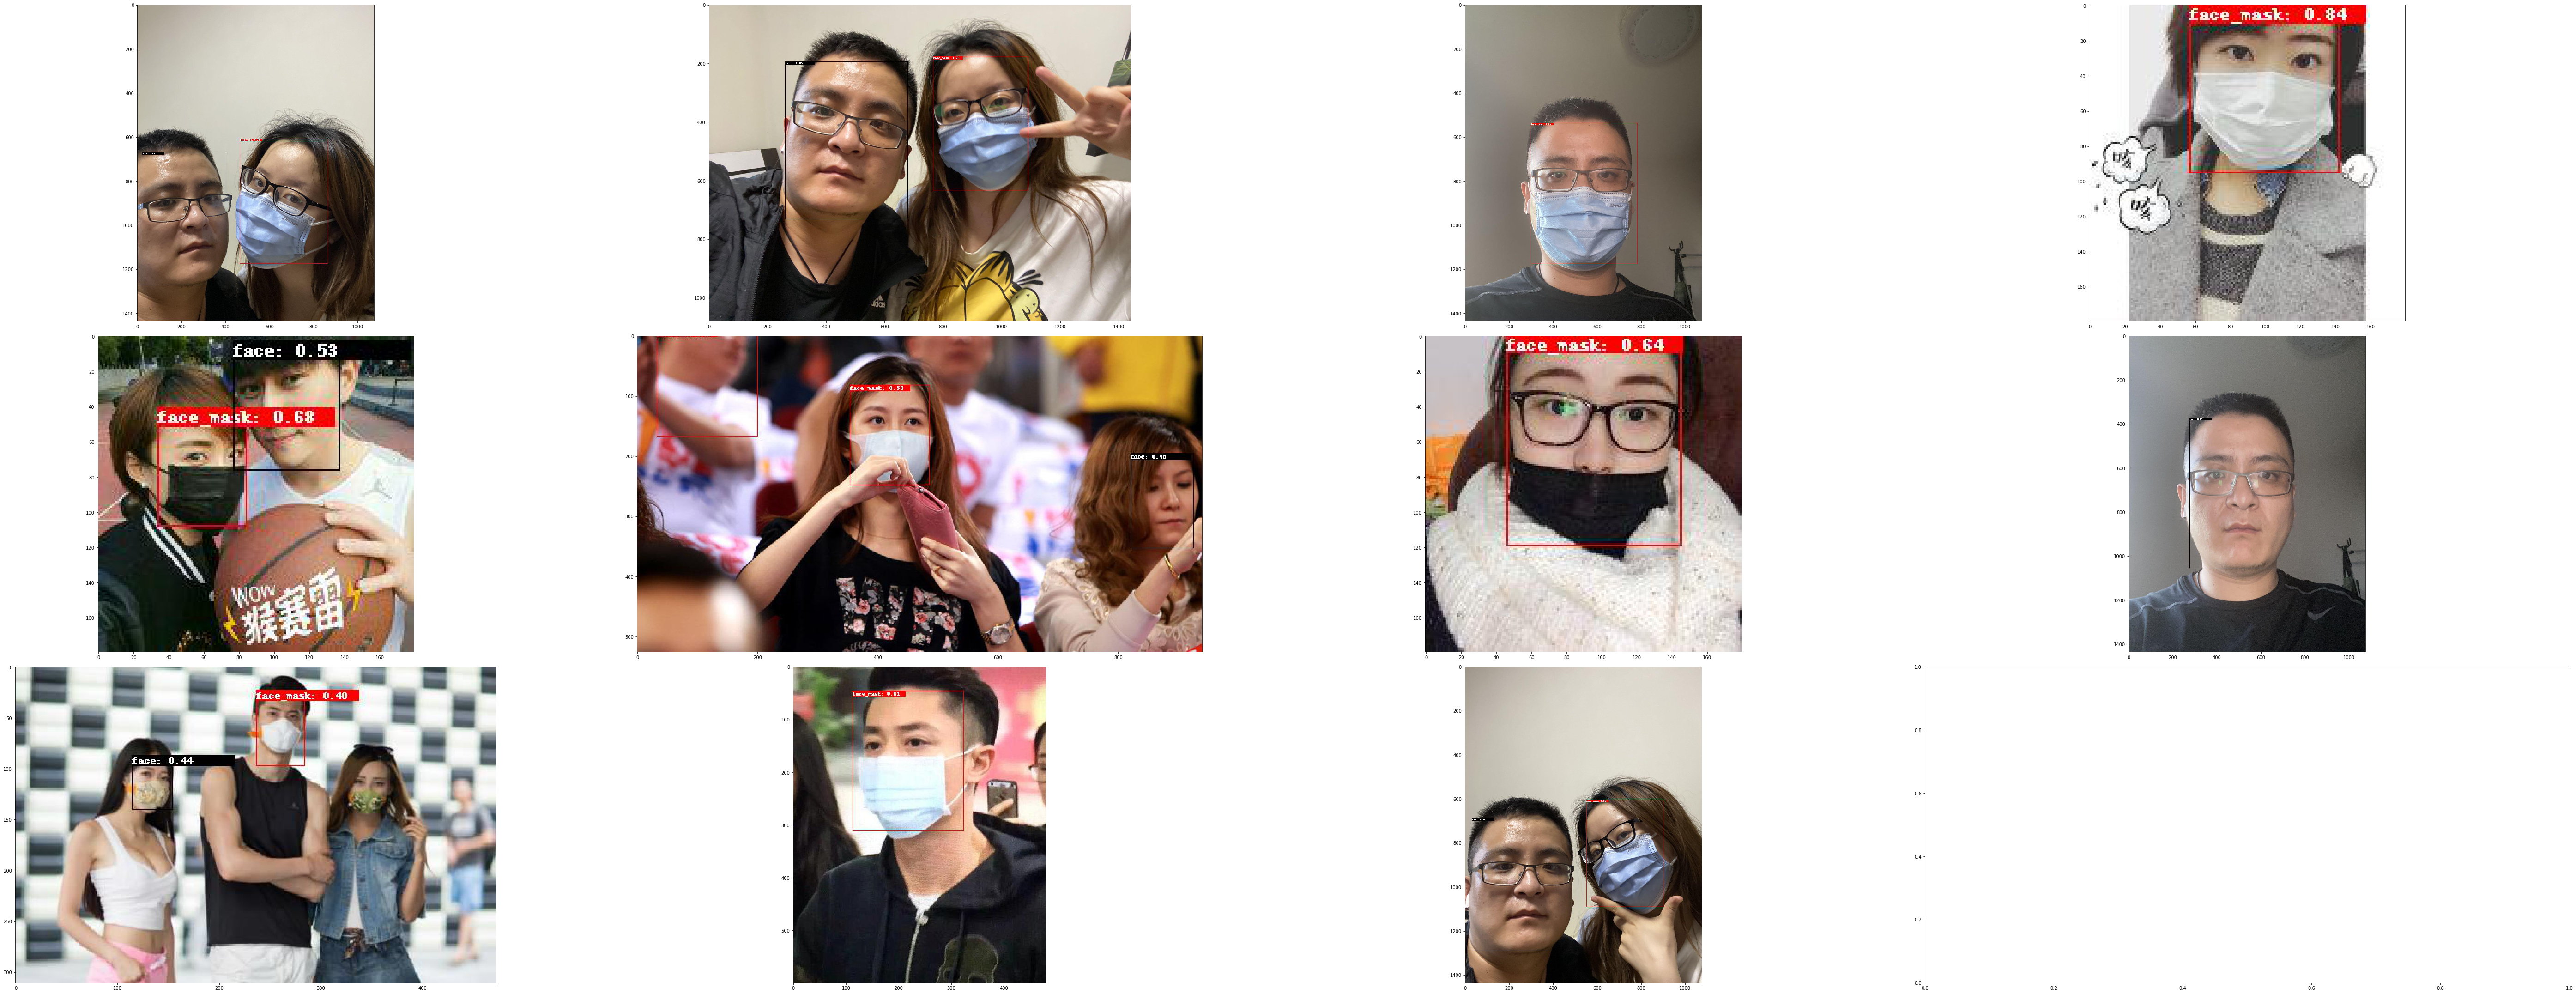

In [38]:
# 在这里执行可视化工具
OUTPUT_PATH = "data/infered_images" # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 9. 模型的导出和部署! <a class="anchor" id="head-9"></a>

In [39]:
!mkdir -p $USER_EXPERIMENT_DIR/export
# 这里导出的是FP32数据类型的模型，您可以通过更改--data_type的参数来更改导出的模型的数据精度
# 比如您可以设置--data_type fp16
!tlt-export ssd -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                -k $KEY \
                -o $USER_EXPERIMENT_DIR/export/ssd_mobilenet_v2_epoch_040.etlt \
                -e $SPECS_DIR/ssd_retrain_mobilenet_v2_kitti.txt  \
                --batch_size 1 \
                --data_type fp32

# 这里有直接导出INT 8 的数据类型的模型的命令 \
# !tlt-export ssd -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_resnet18_epoch_$EPOCH.tlt  \
#                 -o $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt \
#                 -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
#                 -k $KEY \
#                 --cal_image_dir  $USER_EXPERIMENT_DIR/data/testing/image_2 \
#                 --data_type int8 \
#                 --batch_size 1 \
#                 --batches 10 \
#                 --cal_cache_file $USER_EXPERIMENT_DIR/export/cal.bin  \
#                 --cal_data_file $USER_EXPERIMENT_DIR/export/cal.tensorfile

Using TensorFlow backend.
2020-05-28 04:09:24,803 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace-hekun/mydata/tlt-tensorrt-nano/specs/ssd_retrain_mobilenet_v2_kitti.txt
2020-05-28 04:09:29,802 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace-hekun/mydata/tlt-tensorrt-nano/specs/ssd_retrain_mobilenet_v2_kitti.txt
NOTE: UFF has been tested with TensorFlow 1.14.0.
Converting NMS as custom op: NMS_TRT
Converting FirstDimTile_5 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_4 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_3 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_2 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_1 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_0 as custom op: BatchTilePlugin_TRT
DEBUG [/usr/lib/python2.7/dist-packages/uff/converters/tensorflow/converter.py:96] Marking ['NMS'] as out

In [63]:
# 这里展示了tlt-export所有的参数
!tlt-export

Using TensorFlow backend.
usage: tlt-export [-h] -m MODEL -k KEY [-o OUTPUT_FILE]
                  [--cal_data_file CAL_DATA_FILE]
                  [--cal_image_dir CAL_IMAGE_DIR]
                  [--data_type {fp32,fp16,int8}]
                  [--cal_cache_file CAL_CACHE_FILE] [--batches BATCHES]
                  [--max_workspace_size MAX_WORKSPACE_SIZE]
                  [--max_batch_size MAX_BATCH_SIZE] [--batch_size BATCH_SIZE]
                  [-e EXPERIMENT_SPEC] [--engine_file ENGINE_FILE] [-v]
                  {classification,detectnet_v2,ssd,dssd,faster_rcnn,yolo,retinanet}
tlt-export: error: too few arguments


In [41]:
# 这里查看导出的模型
print('导出模型:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/export

Exported model:
------------
total 6.9M
-rw-r--r-- 1 root root 3.5M May 28 04:09 ssd_mobilenet_v2_epoch_040.etlt
-rw-r--r-- 1 root root 3.5M May 28 04:11 trt--mobilenet_v2_epoch_040.engine


您可以通过Docker里面自带的`tlt-converter`工具来转换模型
`tlt-converter`工具将会将您训练出来的.etlt模型直接转换成可以部署在NVIDIA TensorRT和Deepstream 上的格式。对于x86设备，您可以直接复制docker中的工具到您自己的环境中
但是对于Jetson设备，您需要从下面的网址下载
[https://developer.nvidia.com/tlt-converter](https://developer.nvidia.com/tlt-converter)

In [40]:
# 转换成TensorRT engine (FP32)
!tlt-converter -k $KEY \
               -d 3,300,300 \
               -o NMS \
               -e $USER_EXPERIMENT_DIR/export/trt--mobilenet_v2_epoch_040.engine \
               -m 1 \
               -t fp32 \
               -i nchw \
               $USER_EXPERIMENT_DIR/export/ssd_mobilenet_v2_epoch_040.etlt

# Uncomment to convert to TensorRT engine (INT8).
# !tlt-converter -k $KEY  \
#                -d 3,384,1248 \
#                -o NMS \
#                -c $USER_EXPERIMENT_DIR/export/cal.bin \
#                -e $USER_EXPERIMENT_DIR/export/trt.engine \
#                -b 8 \
#                -m 1 \
#                -t int8 \
#                -i nchw \
#                $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt

[INFO] Detected 1 inputs and 2 output network tensors.


In [42]:
#查看转换好的推理引擎
print('Exported engine:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/export/trt*.engine

Exported engine:
------------
-rw-r--r-- 1 root root 3.5M May 28 04:11 /workspace-hekun/mydata/tlt-tensorrt-nano/export/trt--mobilenet_v2_epoch_040.engine


## 10. 确认导出模型 <a class="anchor" id="head-10"></a>
通过下面的命令来确认导出的engine文件是否可以正确运行

In [43]:
# 使用TensorRT engine文件进行推理
# 注意这里的tlt-infer 工具只支持batchsize为1，这点非常重要. 
# 所以请确认在使用tlt-converter工具时 ,使用`-m 1 --batch_size 1`为参数


!tlt-infer ssd --trt -p $USER_EXPERIMENT_DIR/export/trt--mobilenet_v2_epoch_040.engine \
                     -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
                     -i $DATA_DOWNLOAD_DIR/infer_images \
                     -o $USER_EXPERIMENT_DIR/ssd_infer_images \
                     -t 0.4

Using TensorFlow backend.
2020-05-28 04:13:17,290 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace-hekun/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
2020-05-28 04:13:17,292 [INFO] iva.ssd.scripts.inference_trt: Loading cached TensorRT engine from /workspace-hekun/mydata/tlt-tensorrt-nano/export/trt--mobilenet_v2_epoch_040.engine
[TensorRT] WARNING: Current optimization profile is: 0. Please ensure there are no enqueued operations pending in this context prior to switching profiles
100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 23.52it/s]


In [46]:
!echo $KEY

cTJhcms3ODdvbHRsOWwxMTNvYW0yN3NuaHA6YjU2YjE1ZjgtNDk5Ni00NTY5LWE0MDAtMjMwNzgwZWE5MGFj
